<a href="https://colab.research.google.com/github/mashyko/object_detection/blob/master/alexnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of AlexNet with Cifar-10 by Pytorch

adapted from :　http://cedro3.com/ai/pytorch-alexnet/


In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# load CIFA-10 data
train_dataset = torchvision.datasets.CIFAR10(
      root='./data/',
      train=True, 
      transform=transforms.ToTensor(),
      download=True)
 
test_dataset = torchvision.datasets.CIFAR10(
      root='./data/',
      train=False, 
      transform=transforms.ToTensor(),
      download=True)
 
print ('train_dataset = ', len(train_dataset))
print ('test_dataset = ', len(test_dataset))
image, label = train_dataset[0]
print (image.size())
 

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
train_dataset =  50000
test_dataset =  10000
torch.Size([3, 32, 32])


In [0]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,
      batch_size=64, 
      shuffle=True,
      num_workers=2)
 
test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)
 

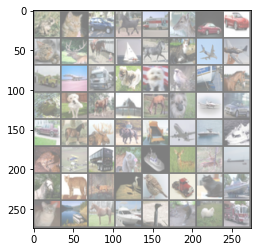

In [0]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [0]:

# Alexnet
class AlexNet(nn.Module):
 
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
 
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

# select device
num_classes = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)
 
# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
 


In [0]:
# training
num_epochs = 20
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
 
### training
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ====== train_mode ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    # ====== val_mode ======
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    
 


Epoch [1/20], Loss: 0.0352, val_loss: 0.0320, val_acc: 0.2345
Epoch [2/20], Loss: 0.0284, val_loss: 0.0246, val_acc: 0.4004
Epoch [3/20], Loss: 0.0232, val_loss: 0.0235, val_acc: 0.4761
Epoch [4/20], Loss: 0.0194, val_loss: 0.0183, val_acc: 0.5880
Epoch [5/20], Loss: 0.0167, val_loss: 0.0159, val_acc: 0.6433
Epoch [6/20], Loss: 0.0145, val_loss: 0.0144, val_acc: 0.6759
Epoch [7/20], Loss: 0.0127, val_loss: 0.0124, val_acc: 0.7251
Epoch [8/20], Loss: 0.0113, val_loss: 0.0131, val_acc: 0.7138
Epoch [9/20], Loss: 0.0102, val_loss: 0.0120, val_acc: 0.7345
Epoch [10/20], Loss: 0.0092, val_loss: 0.0108, val_acc: 0.7623
Epoch [11/20], Loss: 0.0083, val_loss: 0.0106, val_acc: 0.7678
Epoch [12/20], Loss: 0.0073, val_loss: 0.0104, val_acc: 0.7744
Epoch [13/20], Loss: 0.0067, val_loss: 0.0106, val_acc: 0.7742
Epoch [14/20], Loss: 0.0059, val_loss: 0.0101, val_acc: 0.7960
Epoch [15/20], Loss: 0.0052, val_loss: 0.0115, val_acc: 0.7721
Epoch [16/20], Loss: 0.0047, val_loss: 0.0104, val_acc: 0.7964
E

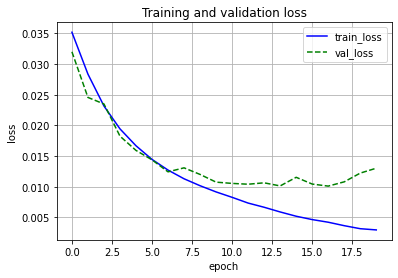

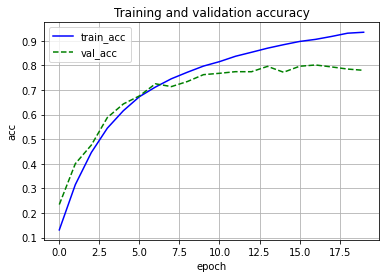

In [0]:
# plot graph
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
 
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
 

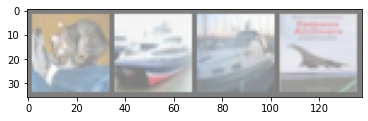

GroundTruth:    cat  ship  ship plane


In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [0]:

net = AlexNet(num_classes)

net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat  ship  ship  ship


以上
